<a href="https://colab.research.google.com/github/motor17/Anomaly-Detection/blob/main/Final_Anomaly_Detection_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is the most basic code for anomaly detection. It also creates an excel file containing the anomalous data points.

In [ ]:


from IPython import get_ipython
from IPython.display import display
import openpyxl
import numpy as np
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets

# Load the workbook
workbook = openpyxl.load_workbook('/content/IdVg (1).xlsx')
sheet = workbook.active

# Extract Vgate and Idrain values
Vgate_values = [sheet[f'B{row}'].value for row in range(125, 181)]
Idrain_values = [sheet[f'E{row}'].value for row in range(125, 181)]

# Calculate Gm using point-to-point method
Gm_values = []
for i in range(1, len(Vgate_values)):
    Vgate_current = Vgate_values[i]
    Vgate_previous = Vgate_values[i - 1]
    Idrain_current = Idrain_values[i]
    Idrain_previous = Idrain_values[i - 1]

    if Vgate_current != Vgate_previous:
        Gm = (Idrain_current - Idrain_previous) / (Vgate_current - Vgate_previous)
        Gm_values.append(Gm)
    else:
        Gm_values.append(None)  # Or any other value to indicate an error

# Replace None values with 0 for Isolation Forest (if any)
Gm_values = [0 if x is None else x for x in Gm_values]


# Prepare data for Isolation Forest
X = np.array(list(zip(Vgate_values[1:], Gm_values)))  # Combine Vgate and Gm

# Create and train Isolation Forest model
model = IsolationForest(contamination='auto', random_state=42)  # Adjust contamination if needed
model.fit(X)

# Get anomaly scores
anomaly_scores = model.decision_function(X)

# --- Interactive Slider ---
!pip install ipywidgets==8.0.6

def update_plot(anomaly_threshold):
    anomalies = X[anomaly_scores < anomaly_threshold]

    # Create a new Excel workbook to store anomalies
    anomaly_workbook = openpyxl.Workbook()
    anomaly_sheet = anomaly_workbook.active
    anomaly_sheet.append(["Vgate", "Gm"])  # Header row

    for anomaly in anomalies:
        anomaly_sheet.append([anomaly[0], anomaly[1]])

    anomaly_workbook.save("anomalous_data.xlsx")  # Save the Excel file

    plt.figure(figsize=(8, 6))
    plt.scatter(Vgate_values[1:], Gm_values, label='Original Data')
    plt.scatter(anomalies[:, 0], anomalies[:, 1], color='red', label='Anomalies')
    plt.xlabel('Vgate (V)')
    plt.ylabel('Gm (S)')
    plt.title('Anomaly Detection using Isolation Forest')
    plt.legend()
    plt.grid(True)
    plt.show()

slider = widgets.FloatSlider(
    value=-0.08,
    min=-5,
    max=2,
    step=0.01,
    description='Anomaly Threshold:',
    continuous_update=True
)

interact(update_plot, anomaly_threshold=slider)
# --- End of Interactive Slider ---

interactive(children=(FloatSlider(value=-0.08, description='Anomaly Threshold:', max=2.0, min=-5.0, step=0.01)…

<function __main__.update_plot(anomaly_threshold)>

Now, as a scatter plot is not the only way of observing anomalies using this method we shall use another code to detect anomalies in a different manner visually.

In [ ]:


import matplotlib.pyplot as plt

# Assuming X, Vgate_values, Gm_values, and anomaly_scores are defined from the previous code

def update_plot_2(anomaly_threshold):
    anomalies = X[anomaly_scores < anomaly_threshold]

    # Create the figure and axes
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot Gm values
    ax1.plot(Vgate_values[1:], Gm_values, label='Gm', color='blue')
    ax1.set_xlabel('Vgate (V)')
    ax1.set_ylabel('Gm (S)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Create a second y-axis for anomaly scores
    ax2 = ax1.twinx()
    ax2.plot(Vgate_values[1:], anomaly_scores, label='Anomaly Score', color='red', linestyle='--')
    ax2.set_ylabel('Anomaly Score', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    # Highlight anomalies
    for i in range(len(anomaly_scores)):
        if anomaly_scores[i] < anomaly_threshold:
            ax1.scatter(Vgate_values[i+1], Gm_values[i], color='red', s=50, label='Anomaly' if i==0 else "")

    plt.title('Anomaly Detection using Isolation Forest')
    fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
    plt.grid(True)
    plt.show()

slider_2 = widgets.FloatSlider(
    value=-0.1116,
    min=-5,
    max=2,
    step=0.01,
    description='Anomaly Threshold:',
    continuous_update=True
)


interact(update_plot_2, anomaly_threshold=slider_2)

interactive(children=(FloatSlider(value=-0.1116, description='Anomaly Threshold:', max=2.0, min=-5.0, step=0.0…

<function __main__.update_plot_2(anomaly_threshold)>

Anomaly score map to double check too

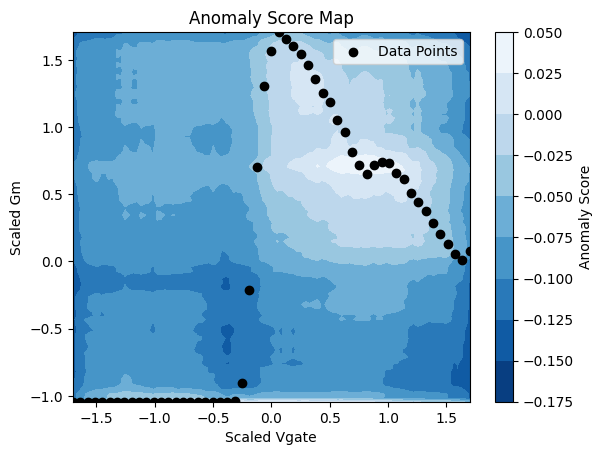

In [ ]:
import openpyxl
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# ... (Load data, calculate Gm, etc. - same as your existing code) ...

# Prepare data for Isolation Forest
X = np.array(list(zip(Vgate_values[1:], Gm_values)))

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create and train Isolation Forest model
model = IsolationForest(contamination='auto', random_state=42)
model.fit(X_scaled)

# Get anomaly scores
anomaly_scores = model.decision_function(X_scaled)

# Create a meshgrid for the anomaly score map
xx, yy = np.meshgrid(np.linspace(X_scaled[:, 0].min(), X_scaled[:, 0].max(), 100),
                     np.linspace(X_scaled[:, 1].min(), X_scaled[:, 1].max(), 100))

# Predict anomaly scores for the meshgrid points
Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the anomaly score map
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)  # Use a colormap to visualize scores
plt.colorbar(label='Anomaly Score')

# Plot the original data points
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c='black', marker='o', label='Data Points')

plt.xlabel('Scaled Vgate')
plt.ylabel('Scaled Gm')
plt.title('Anomaly Score Map')
plt.legend()
plt.show()